### CNNMLP Implementation
- Based on [Joo et al., 2023](https://www.nature.com/articles/s41598-023-49514-2#)

In [ ]:
import sys, warnings

import matplotlib.pyplot as plt
import pandas as pd

import torch, gc
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary

from tqdm.auto import tqdm
from pyprojroot import here

sys.path.insert(0, f"{here()}/src")

from cnn_classifier import CNNMLP
from dataset import MRIDataset


warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)
pd.reset_option("mode.chained_assignment")

PyTorch version: 2.7.1+cu128
torchvision version: 0.22.1+cu128


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
gc.collect()
torch.cuda.empty_cache()

In [4]:
!nvidia-smi

Tue Aug  5 13:34:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.03              Driver Version: 575.64.03      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        Off |   00000000:01:00.0  On |                  N/A |
| 30%   41C    P8             57W /  575W |     723MiB /  32607MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
proj_dir = here()

In [6]:
torch.manual_seed(42)
cnnmodel = CNN1(input_shape=1).to(device)
#base_model

In [7]:
summary(model=cnnmodel, input_size=(4, 1, 121, 145, 121))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1                                     [4, 512, 3, 4, 3]         --
├─Conv3d: 1-1                            [4, 32, 119, 143, 119]    896
├─BatchNorm3d: 1-2                       [4, 32, 119, 143, 119]    64
├─ReLU: 1-3                              [4, 32, 119, 143, 119]    --
├─MaxPool3d: 1-4                         [4, 32, 59, 71, 59]       --
├─Conv3d: 1-5                            [4, 64, 59, 71, 59]       55,360
├─BatchNorm3d: 1-6                       [4, 64, 59, 71, 59]       128
├─ReLU: 1-7                              [4, 64, 59, 71, 59]       --
├─MaxPool3d: 1-8                         [4, 64, 29, 35, 29]       --
├─Conv3d: 1-9                            [4, 128, 29, 35, 29]      221,312
├─BatchNorm3d: 1-10                      [4, 128, 29, 35, 29]      256
├─ReLU: 1-11                             [4, 128, 29, 35, 29]      --
├─MaxPool3d: 1-12                        [4, 128, 14, 17, 14]      --
├─C

In [8]:
mlpmodel = MLPSex(input_shape=1).to(device)

In [9]:
summary(model=mlpmodel, input_size=(4, 1))

Layer (type:depth-idx)                   Output Shape              Param #
MLPSex                                   [4, 8]                    --
├─Linear: 1-1                            [4, 32]                   64
├─ReLU: 1-2                              [4, 32]                   --
├─Linear: 1-3                            [4, 16]                   528
├─ReLU: 1-4                              [4, 16]                   --
├─Linear: 1-5                            [4, 8]                    136
Total params: 728
Trainable params: 728
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [10]:
model = CNNMLP(cnnmodel=cnnmodel, mlpmodel=mlpmodel, combined_dim=18440).to(device)

In [11]:
summary(model)

Layer (type:depth-idx)                   Param #
CNNMLP                                   --
├─CNN1: 1-1                              --
│    └─Conv3d: 2-1                       896
│    └─BatchNorm3d: 2-2                  64
│    └─ReLU: 2-3                         --
│    └─MaxPool3d: 2-4                    --
│    └─Conv3d: 2-5                       55,360
│    └─BatchNorm3d: 2-6                  128
│    └─ReLU: 2-7                         --
│    └─MaxPool3d: 2-8                    --
│    └─Conv3d: 2-9                       221,312
│    └─BatchNorm3d: 2-10                 256
│    └─ReLU: 2-11                        --
│    └─MaxPool3d: 2-12                   --
│    └─Conv3d: 2-13                      884,992
│    └─BatchNorm3d: 2-14                 512
│    └─ReLU: 2-15                        --
│    └─MaxPool3d: 2-16                   --
│    └─Conv3d: 2-17                      3,539,456
│    └─BatchNorm3d: 2-18                 1,024
│    └─ReLU: 2-19                        --

In [12]:
#neuralnet = NeuralNetwork(input_shape=1, hidden_units=32).to(device)

In [13]:
#summary(model=neuralnet)

#### Load Training Data

In [14]:
train_data_directory = "/home/murage/Documents/data/train/" #"/home/Murage/BrainAgefMRI/data/mri/"
validation_data_directory = "/home/murage/Documents/data/validation/" 
pheno_directory = "/home/murage/Documents/data/mri_phenotype_partitioned.csv" #"/shared/uher/Murage/BrainAgefMRI/data/mri_phenotype_partitioned.csv" 

In [15]:
df = pd.read_csv(pheno_directory)
df['filename'] = df['filename'] + '.gz'
df['filename'] = df['filename'].str.strip()

In [16]:
# Save train and validation filenames into list
train = df[df['split'] == 'TRAINING']
validation = df[df['split'] == 'VALIDATE']
train_ids = train['filename'].to_list()
validation_ids = validation['filename'].to_list()

print(f" Train N: {len(train_ids)} | Validation N: {len(validation_ids)}") 

 Train N: 2312 | Validation N: 570


In [17]:
!ls /home/murage/Documents/data/train/ | wc -l

2312


In [18]:
!ls /home/murage/Documents/data/validation/ | wc -l

570


In [19]:
train = train[['filename', 'scan_age', 'sex', 'project']]
validation = validation[['filename', 'scan_age', 'sex', 'project']]

In [20]:
train.sample()

,filename,scan_age,sex,project
2426,PING-sub-P0268.nii.gz,19.833333,Female,PING


#### Train DataLoader

In [21]:
train_dataset = MRIDataset(df=train, id_col='filename', target_col='scan_age', sex_col='sex', root_dir=train_data_directory)
validation_dataset = MRIDataset(df=validation, id_col='filename', target_col='scan_age', sex_col='sex', root_dir=validation_data_directory)

TypeError: MRIDataset.__init__() got an unexpected keyword argument 'sex_col'

In [ ]:
for i in range(5):
    try:
        image, sex, label = train_dataset[i]
        print(f"Index: {i}, {sex}, Image shape: {image.shape if hasattr(image, 'shape') else type(image)}, Label: {label}")
    except KeyError:
        print(f"Index: {i}, {sex}, Image shape: {image.shape if hasattr(image, 'shape') else type(image)}, Label: {label}")
        #print(f"Index {i}: not found")

Index: 0, tensor([0.]), Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([9.4884])
Index: 1, tensor([1.]), Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([11.8236])
Index: 2, tensor([0.]), Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([16.4967])
Index: 3, tensor([0.]), Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([13.4637])
Index: 4, tensor([0.]), Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([12.9977])


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=False, pin_memory=True)

In [ ]:
optimizer = torch.optim.Adam(cnnmodel.parameters(), lr=0.001)

In [ ]:
#cnnmodel, tracking_loss = train_and_select_best_model(model=model, train_dataloader=train_dataloader, 
#                    validation_dataloader=validation_dataloader, optimizer=optimizer, loss=mae, device=device, num_epochs=20, name='cnn')

In [ ]:
image, sex, label = next(iter(train_dataloader))
#print(f'{image.shape}, {sex}: {label}')

In [ ]:
model, tracking_loss = train_model(
    model=model, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, optimizer=optimizer,
    device=device, num_epochs=20, name='cnmlp'
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
-------
Train Loss: 4.9594 | Validation MAE: 5.7834 
Model saved with validation loss: 5.7834
Epoch: 2
-------
Train Loss: 3.7506 | Validation MAE: 3.4826 
Model saved with validation loss: 3.4826
Epoch: 3
-------
Train Loss: 3.7128 | Validation MAE: 3.3067 
Model saved with validation loss: 3.3067
Epoch: 4
-------
Train Loss: 3.5186 | Validation MAE: 4.9975 
Epoch: 5
-------
Train Loss: 3.6267 | Validation MAE: 2.6551 
Model saved with validation loss: 2.6551
Epoch: 6
-------
Train Loss: 3.4109 | Validation MAE: 5.7232 
Epoch: 7
-------
Train Loss: 3.4183 | Validation MAE: 4.2799 
Epoch: 8
-------
Train Loss: 3.4536 | Validation MAE: 7.2108 
Epoch: 9
-------
Train Loss: 3.3827 | Validation MAE: 8.0790 
Epoch: 10
-------
Train Loss: 3.3277 | Validation MAE: 11.8034 
Epoch: 11
-------
Train Loss: 3.3299 | Validation MAE: 5.3339 
Early stopping at epoch 11


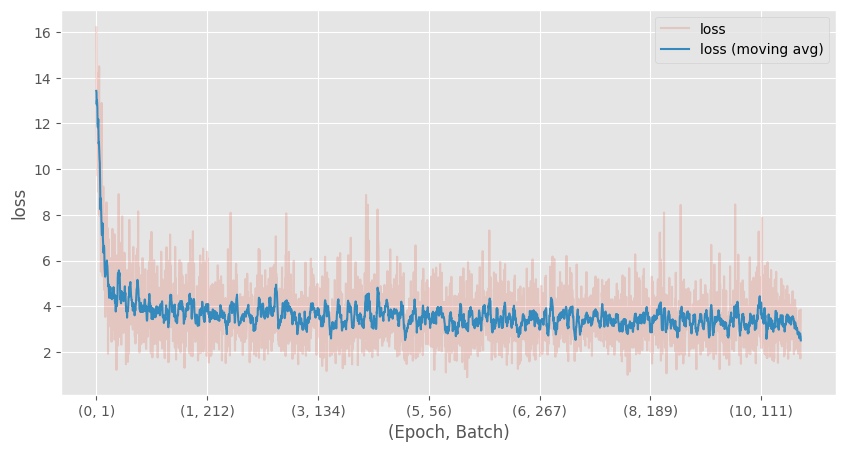

In [ ]:
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10,5))
tracking_loss.plot(alpha=0.2, label='loss')
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)")

plt.xlabel("(Epoch, Batch)")
plt.ylabel("loss")
plt.legend(loc=0)
plt.show()